# Biodiversity Intactness Index Change in Phoenix, AZ (2017-2020)

### By Kaiju Morquecho

[Github Repository](https://github.com/kaimorquecho/eds220_biodiversity_phoenix_az.git)

### Repository Structure 
```
├── .gitignore
├── biodiversity_intactness_arizona.ipynb
├── README.md
└── data  
    │   tl_2020_04_tract 
        | tl_2020_04_tract.shp
```

### About

### Data

- The **Biodiversity Intactness Index (BII) Time Series** is a biodiversity indicator that measures changes in biodiversity using abudance data on plants, fungi, and animals. As a time series, the **BII** captures the effects of human interaction and resource use on species abundance over time. The **BII** collection, ID `io-biodiversity` can be accessed by signining into the **[Microsoft Planetary Computer (MPC)](https://planetarycomputer.microsoft.com/dataset/io-biodiversity)** using the `pystac-client` library to query the STAC API. The `planetary computer` signs items.

- The Phoenix, AZ subdivision area polygon is obtained from the U.S Census Bureau TIGER Shapefile of Arizona County Subdivisions, and is used to outline the area of interest in this analysis. The data can be accessed on the [Data.gov website](https://catalog.data.gov/dataset/tiger-line-shapefile-current-state-arizona-county-subdivision) and is tittled 'TIGER/Line Shapefile, Current, State of Arizona: County Subdivisions'.

### References 
Microsoft Planetary Computer. (n.d.). io-biodiversity [STAC collection]. Accessed December 4, 2025, from https://planetarycomputer.microsoft.com/dataset/io-biodiversity

U.S. Census Bureau. (2021). TIGER/Line Shapefile, Current, State of Arizona: County Subdivisions [Data set]. Data.gov. Accessed December 4, 2025, from https://catalog.data.gov/dataset/tiger-line-shapefile-current-state-arizona-county-subdivision
 


### Import Libraries and Load Datasets

Aside from the standard libraries such as `numpy` and `matplotlib`, the following specialized libraries were used in this analysis:
- `xarray` to access and analyze netCDF4 files (multidimensional datasets)
- `rioxarray` to extend `xarray` with the `rio` accessor to read and manipulate raster data 
- `contextily` to add basemaps to geospatial visualizations
- `geopandas` to handle vector data such as shapefiles
- `planetary_computer` and `pystac_client` to sign into and retrieve items from the Microsoft Planetary Computer STAC 

In [1]:
# Load libraries 
import numpy as np
import matplotlib.pyplot as plt 
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rioxr
import contextily as ctx # For a basemap

from pystac_client import Client # To access STAC catalogs

import planetary_computer # To sign items from MPC STAC

from IPython.display import Image # For nicer image display

### Load the Phoenix Subdivision Shapefile 
To focus the analysis, I load and use the Arizona county subdivision census shapefile and filter it to Phoenix. I will use the shapefile to clip the BII rasters later in the code. This will ensure that calculations and visualizations I perform are limited to the Phoenix, AZ geographic area.


<Axes: >

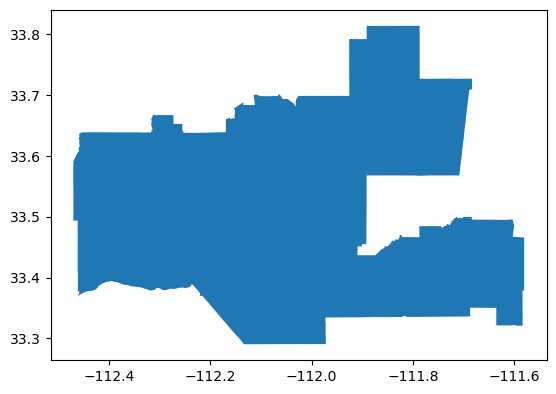

In [37]:
# Load data and filter to Phoenix
phoenix_shape = gpd.read_file('data/tl_2024_04_cousub/tl_2024_04_cousub.shp').query("NAME == 'Phoenix'")

# Take a look at the Phoenix county subdivision
phoenix_shape.plot()

### Access the Biodiversity Intactness Index Collection 

To perform a catalog search, I create a bounding box object containing the coordinates of the polygon for the Phonenix subdivision area, and a variable with the years of interest (2017 and 2020). 

The variables `bbox` and `time_range` can be used to query the `io-biodiversity` collection.

In [13]:
# Access MPC catalog 
catalog = Client.open(
"https://planetarycomputer.microsoft.com/api/stac/v1",
modifier=planetary_computer.sign_inplace
)

# Access the 'io-biodiversity' STAC collection to view its metadata
bio_collection = catalog.get_child('io-biodiversity')
bio_collection

<CollectionClient id=io-biodiversity>

In [25]:
# View spatial and temporal infomration cleanly
print(f'Spatial Extent:\n {bio_collection.extent.spatial.bboxes}')
print(f'Temporal Extent:\n {bio_collection.extent.temporal.intervals}')


Spatial Extent:
 [[-180, -90, 180, 90]]
Temporal Extent:
 [[datetime.datetime(2017, 1, 1, 0, 0, tzinfo=tzutc()), datetime.datetime(2020, 12, 31, 23, 59, 59, tzinfo=tzutc())]]


In [30]:
# Create a bounding box covering the Phoenix subdivision area
bbox = {
    "type":"Polygon",
    "coordinates":[
        [
         [-112.826843, 32.974108],
         [-112.826843, 33.863574],
         [-111.184387, 33.863574],
         [-111.184387, 32.974108],
         [-112.826843, 32.974108]
        ]
    ]
}

# Create variable with time range 
time_range = ['2017-01-01','2020-01-01']

# Search the catalog for the BII collection for the Phoenix Area for years 2017 & 2020
search = catalog.search(
    collections = ['io-biodiversity'],
    intersects = bbox, 
    datetime = time_range
)

# Get the items found in the search
items = search.item_collection()

print(f"There are {len(items)} items in the io-biodiversity collection")


There are 4 items in the io-biodiversity collection


In [11]:

years = ['2017-01-01','2020-01-01']

az_dict= {}

for year in years:
    # Catalog search for 2017 
    search = catalog.search(
    collections = ['io-biodiversity'],
    intersects = bbox,
    datetime = year
)
    items = search.item_collection()

    for item in items:
        
        Image(url=item.assets['rendered_preview'].href,width=500)

        if year not in az_dict:
            az_dict[year] = []
            az_dict[year].append(rioxr.open_rasterio(item.assets['data'].href))
